# Convolutional Neural Networks - Workshop

## GPU Version: high-res rgb images are processed


### Load Modules and Dataset
What is it gonna be? Cats / Dogs or Zebras / Elephants?


In [24]:
# import modules
from keras.preprocessing.image import array_to_img, load_img
import matplotlib.pyplot as plt
import random
import os

# Path to image data
path = 'D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/group1/'
# path = '/host/data/cnn_workshop/EleZebra/'
# path = '/host/data/cnn_workshop/CatDog/'

# get class labels
class_labels = os.listdir(path + 'train')

# image size for training, should be at least (150, 150, 3)
# it doesn't make sense to increase size with respect to original images
# the larger the size the more computationally expensive it is to train a CNN
# recommended for Cat/Dog: (150, 150, 3)
# recommended for Zebra / Elephant: (250, 250, 3)
image_size_for_training = (150, 150, 3)

### Take a look at your images

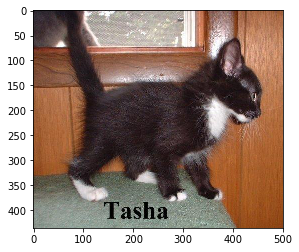

D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/Cat/2973.jpg


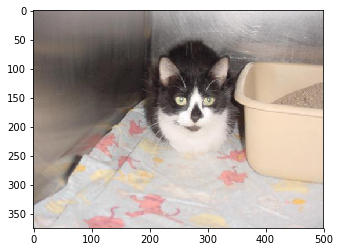

D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/Cat/1119.jpg


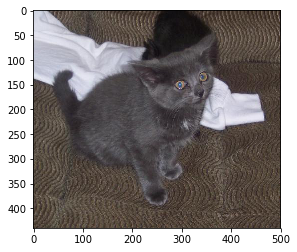

D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/Cat/10241.jpg


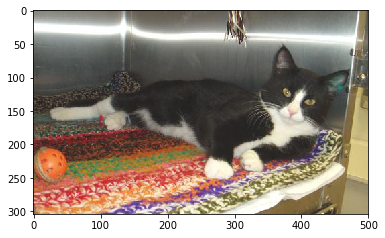

D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/Cat/7428.jpg


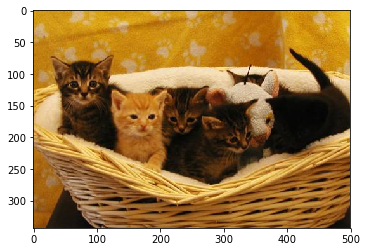

D:/Studium_GD/Zooniverse/Data/cnn_workshop/PetImages/Cat/3220.jpg


IndexError: list index out of range

In [25]:
# Look at some images
def look_at_imgs(path, n=5):
    files = os.listdir(path)
    # choose random images
    random.seed(23)
    random_ids = random.sample(population=range(0, len(files)), k=n)
    random_imgs = [files[x] for x in random_ids]

    # display
    all_imgs = list()
    for i in range(0, len(random_ids)):
        img = load_img(path + random_imgs[i])
        all_imgs.append(img)
        plt.imshow(img)
        plt.show()
        print(path + random_imgs[i])
    
    return all_imgs

random_imgs_0 = look_at_imgs(path + class_labels[0] + '/')
random_imgs_1 = look_at_imgs(path + class_labels[1] + '/')

# collect random images
random_imgs = random_imgs_0
random_img.extend(random_imgs_1)

### Data Generators

Keras ImageDataGenerator implements transformations, pre-processing and serving of image data during training. For example, streaming image batches from a directory while training a model. The data pre-processing & streaming is done on CPU, while the model training is done on GPU to increase efficiency (GPU version).

Data augmentation is a process where images are artificially altered to create 'new'data that is similar to the original data. This helps to increase your data set size & to avoid overfitting. Data augmentation operations are: flipping, cropping & zooming.

Data pre-processing operations like standardizations of pixel values have been shown to increase the efficiency of model training. Operations include: featurewise_center & featurewise_std_normalization.

https://keras.io/preprocessing/image/

In [ ]:
# Create Data Generator
# pre-processing of images
from keras.preprocessing.image import ImageDataGenerator

# batch size, the number of images returned by one call of the data generator
# should be a number between 1 and approx. 256 (can be hardware limiting)
batch_size = 32

# generator for training data - specify pre-processing and transformations here
datagen_train = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# generator for test data (no data augmentation! but the same pre-processing as for the training data)
datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True)

# generator to get raw images to estimate transformation parameters like mean and std of pixel values
datagen_raw = ImageDataGenerator(
    rescale=1./255
    )

raw_gen = datagen_raw.flow_from_directory(
    path + 'train/',
    target_size=image_size_for_training[0:2],
    batch_size=1000,
    class_mode='binary',
    seed=123)

# get a single batch of raw images (1000 images)
X_raw = raw_gen.next()

# fit data generators on raw data to calculate transformations
# use same batch of training data to fit train/test generators
datagen_train.fit(X_raw[0])
datagen_test.fit(X_raw[0])

# fetch data from directory in specified batch sizes for all the generators
train_generator = datagen_train.flow_from_directory(
    path + 'train/',
    target_size=image_size_for_training[0:2],
    batch_size=batch_size,
    class_mode='binary',
    seed=123)

test_generator = datagen_test.flow_from_directory(
    path + 'test/',
    target_size=image_size_for_training[0:2],
    batch_size=batch_size,
    class_mode='binary',
    seed=123)

# dummy data fetcher to look at data
dummy_gen = datagen_train.flow_from_directory(
    path + 'train/',
    target_size=image_size_for_training[0:2],
    batch_size=5,
    class_mode='binary',
    seed=123)

# lets take a look at what the data generator actually does and returns
data_batch = dummy_gen.next()
for i in range(0, len(data_batch[1])):
    print("Label: %s" % data_batch[1][i])
    plt.imshow(array_to_img(data_batch[0][i, :]))
    plt.show()

### Model Architecture
Now we define a model architecture, which consists of sequential layers of operations. The 2 main blocks of a CNN are the convolutional part and the fully connected part.

Convolutional layers: These layers extract features from the input (e.g. edges, corners, patterns). This block starts directly at the beginning (e.g. functions Conv2D()) and typically consists of convolution layers (Conv2d()), followed by an activation (nowadays ReLu activation), and a pooling layer (e.g. MaxPooling2D()). Multiple such constructs can be stacked.
* https://keras.io/layers/convolutional/

The fully connected part represents a classical neural network consisting of an input layer (Flatten()) which takes the features from the convolutional part, some hidden layer(s) (Dense()), and finally an output layer (Dense(), with an activation function that results in probabilities for classification tasks, like sigmoid or softmax).
* https://keras.io/layers/core/

In [10]:
# Define a model architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

In [26]:
# Lets initialize a model 
model = Sequential()
model.add(Conv2D(3, # number of filter layers
                (3,3), # x, y dimension of kernel (we're going for a 3x3 kernel)
                input_shape=image_size_for_training))

# predict our random images on a un-trained network
#conv_cat = model.predict(random_imgs_0[0])
random_imgs[0]

NameError: name 'random_imgs' is not defined

In [ ]:
# sequential model (layer based)
model = Sequential()
# Convolutional layer over 2 dimensions
# 32 filters, each with a size of 3x3 pixels
model.add(Conv2D(32, (3, 3), input_shape=image_size_for_training))
# activation function
model.add(Activation('relu'))
# Aggregate data using max pooling (reduce size of feature maps)
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())
# fully connected layer with 64 output values
model.add(Dense(64))
# applies static function on output
model.add(Activation('relu'))
# randomly set 50% of all outputs to zero to prevent overfitting
model.add(Dropout(0.5))
# fully connected layer with 1 output value
model.add(Dense(1))
# sigmoid transformation (logistic regression) to obtain class probability
model.add(Activation(activation='sigmoid'))


### Model compilation & training
After the model architecture has been defined, we have to compile the model. Important parameters include the optimizer and the loss function. The loss function for binary classifications is 'binary_crossentropy', which is what the model is trying to minimize during the training process. The optimizer defines how the gradients and their updates are calculated. Changing the optimizer can have a great effect on model convergence, if for example one changes to the stochastic gradient descent optimizer and chooses a high learning rate it may be that the model never converges.

* https://keras.io/optimizers/

#### Epochs
Number of full passes over the training data (increase this number to get a better model performance & incrased training time).
#### Batch Size
Number of images simultenously used to calculated one update of the gradients. 1 image is stochastic gradient descent (SGD), N>1 images is mini-batch gradient descent (usually between 32 and 256 images), using n images is gradient descent.
#### Steps_per_epoch
The number of batches as generated by the data generator to process per epoch. We divide the number of samples by the batch size to make one full pass over the training data per epoch.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


# train the model
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=2,
    workers=2,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size)

### Evaluating the model
The model may need a few epochs to learn how to distinct between different species, you can see that by observing the accuracy during training time. After only a few epochs we can take a look at a few predictions of our model.

In [ ]:
# predict on test sample

# get a test batch
test_batch_data = test_generator.next()
# get class information to make correct mapping
classes = test_generator.class_indices
for cl, no in classes.items():
    if no == 1:
        class1 = cl
# calculate predictions
p_test = model.predict_on_batch(test_batch_data[0])

# show some images and their prediction
for i in range(0, len(test_batch_data[1])):
    print("Predicted %s percent of being a %s" %
          (round(float(p_test[i] * 100), 2), class1))
    plt.imshow(array_to_img(test_batch_data[0][i, :]))
    plt.show()

### Pre-Trained Networks
Because training of a CNN requires a lot of computational power and time it is often useful to use a pre-trained CNN as a starting point. Below we download Googles Inception model, their weights from the ImageNet dataset, and we add our own last, fully-connected layer to the network and train it using our images.

Another option is to use the architecture and re-train the model from scratch (without using the model weights). In this case one does not need to worry about how to define the model architecture, because finding a good architecture can take a huge amount of time due to the long evaluation process.

In [ ]:
# Load a pre-trained model
from keras.applications.inception_v3 import InceptionV3

# load Googles inception model with imagenet weights
base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=image_size_for_training)

# take a look at its architecture
base_model.summary()

# set convolutional layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False


# add fully connected output layer to model
top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = Dense(1, activation='sigmoid')(top_model)

# this is the model we will train (pre-trained convoltional part
# and top layer)
model = Model(inputs=base_model.input, outputs=top_model)

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# look at model architecture
model.summary()

# feed data to the training pre-processing
# WARNING: make sure the pre-processing is the same as used to train the
# pre-trained model
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=5,
    workers=2,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size)
